In [1]:
%reset -f
%matplotlib inline

In [2]:
import pyross
import numpy as np
import matplotlib.pyplot as plt

# Introduction: Forecast for SEAIRQ model with stochastic parameters

In this notebook, we consider the SEAIRQ model. 

We assume that the parameters 

* $\beta$ (probability of infection on contact),
* $\gamma_{E}$ (rate of progression for exposed individual to class A), 
* $\gamma_{AA}$ (rate of progression from class A to asymptomatic infective class), 
* $\gamma_{AS}$ (rate of progression from class A to symptomatic infective class), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 
* $ \tau_S$ (quarantining rate for susceptibles)
* $ \tau_E$ (quarantining rate for exposed)
* $ \tau_A$ (quarantining rate for A)
* $ \tau_{I_a}$ (quarantining rate for asymptomatic infectives)
* $ \tau_{I_s}$ (quarantining rate for symptomatic infectives)

are not known exactly, but rather are characterized by a 11D Gaussian distribution with known mean and covariance matrix. The Gaussian distribution function is set to zero if any of the parameters is $< 0$.

**We now illustrate how uncertainties in the parameters affect the predictions of the SEAIRQ model.**

For this we simulate the SEIR model $N_s = 500$ times; for each simulation the above parameters are sampled from a given 11D Gaussian distribution. The resulting 500 trajectories are shown together with their mean, standard deviation, median, and 5 as well as 95 percentiles.

We perform this analysis for the deterministic SEAIRQ model.

# Define model parameters and initialise pyross.forecast.SEAIRQ

In [3]:
M = 1                  # the SEAIRQ model we consider has no age structure
Ni = 50000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group


E0  = np.array([0])
A0  = np.array([1])
Ia0 = np.array([0])     # the SEAIRQ model we consider has only one kind of infective 
Is0 = np.array([20])     # we take these to be symptomatic 
Q0  = np.array([0])
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0+E0)    # The initial susceptibles are obtained from S + E + A + Ia + Is + R = N


# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and output datapoints
Tf = 500;  Nt=Tf+1


# These parameters we consider exact
alpha = 0.0            # fraction of asymptomatic infectives 
fsa   = 1              # the self-isolation parameter 

# These are the parameters that we sample stochastically
# means
beta  = 0.2            # infection rate
gE    = 0.3             # progression rate from E to A
gAA   = 0.2            # rate to go from A to Ia
gAS   = 0.3            # rate to go from A to Is
gIa   = 0.1            # recovery rate of asymptomatic infectives 
gIs   = 0.1            # recovery rate of symptomatic infectives 
gE    = 0.04           # recovery rate of E
fsa   = 1              # the self-isolation parameter 
#
tS    = 0.0            # rate S  -> Q
tE    = 0.00           # rate E  -> Q
tA    = 0.00           # rate A  -> Q
tIa   = 0.00           # rate Ia -> Q
tIs   = 0.05           # rate Is -> Q


# order in covariance matrix:
# beta, gE, gAA, gAS, gIa, gIs, tS, tE, tA, tIa, tIs
#
cov = np.zeros([11,11],dtype=float)
cov[0,0] = 0.01 # cov(beta, beta) = Var(beta)
cov[1,1] = 0.001 # cov(gE, gE) = Var(gE)
cov[2,2] = 0.0001 # cov(gAA, gAA) = Var(gAA)
cov[3,3] = 0.0001 # cov(gAS, gAS) = Var(gAS)
cov[4,4] = 0.001 # cov(gIa,gIa) = Var(gIa)
cov[5,5] = 0.001 # cov(gIs,gIs) = Var(gIs)
cov[6,6] = 0. # cov(tS,tS) = Var(tS)
cov[7,7] = 0. # cov(tE,tE) = Var(tE)
cov[8,8] = 0. # cov(tA,tA) = Var(tA)
cov[9,9] = 0. # cov(tIa,tIa) = Var(tIa)
cov[10,10] = 0.005 # cov(tIs,tIs) = Var(tIs)
# 
cov[0,1] = 0.001 # cov(beta, gE)
cov[1,0] = cov[0,1] # covariance matrix is symmetric
#
cov[2,3] = cov[2,2] # cov(gAA, gAS)
cov[3,2] = cov[2,3] 
# setting cov(gAA, gAS) = Var(gAA) = Var(gAS) here
# means that we assume gAA and gAS to be equal

cov[4,5] = cov[4,4] # cov(gIa, gIs)
cov[5,4] = cov[4,5] 



# Define parameters for simulations
parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gAA':gAA,'gAS':gAS,
              'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs,
             'cov':cov
                }

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAIRQ(parameters, M, Ni)


# Number of simulations over which we average
Ns = 500 

In [4]:
# Define a function which we use below to plot simulation results
def plot_trajectories(result,
                percentile=-1,
                plot_index = 4, # which time series should be plotted? 
               filename='None'): # set filename for saving figures
    # plot_index   class
    #   0          susceptibles
    #   1          exposed
    #   2          asymptomatic and infectious
    #   3          asymptomatic infectives
    #   4          symptomatic infectives
    #   5          quarantined
    if plot_index == 0:
        title='Susceptibles'
        ylabel = r'$N_S$'
    elif plot_index == 1:
        title='Exposed'
        ylabel = r'$N_{E}$'
    elif plot_index == 2:
        title=r'Asymptomatic, infectious (A)'
        ylabel = r'$N_{A}$'
    elif plot_index == 3:
        title='Asymptomatic infectives'
        ylabel = r'$N_{I,a}$'
    elif plot_index == 4:
        title='Symptomatic infectives'
        ylabel = r'$N_{I,s}$'
    elif plot_index == 5:
        title='Quarantined'
        ylabel = r'$N_{Q}$'
    else:
        raise RuntimeError("plot_index should be 0, 1, 2, or 3.")
    #
    fontsize=25
    #
    #
    trajectories = result['X']
    t_arr = result['t']
    traj_mean = result['X_mean']
    traj_std = result['X_std']
    #
    #
    # Plot trajectories
    #
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,
                 y=1.05,
                fontsize=fontsize)
    for i,e in enumerate(trajectories):
        ax.plot(t_arr,e[plot_index],
                alpha=0.15,
               )
    ax.fill_between(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                    traj_mean[plot_index] + traj_std[plot_index],
                    alpha=0.7,
                    color='limegreen',
                           label='Std deviation')
    ax.plot(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                    alpha=1,
            label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean[plot_index] + traj_std[plot_index],
                    alpha=1,
            #label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean[plot_index],
                    alpha=1,
            lw=2,
            color='black',
           label='Mean')
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    ax.legend(loc='upper right',fontsize=18)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_trajs.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #
    #
    #
    # Plot percentiles
    #
    if percentile > 0:
        percentiles_lower = np.percentile(trajectories[:,plot_index],percentile,axis=0)
        percentiles_upper = np.percentile(trajectories[:,plot_index],100-percentile,axis=0)
        percentiles_median = np.percentile(trajectories[:,plot_index],50,axis=0)
        print("In the following plot, red dashed lines denote {0} and {1} percentiles of the numerical data:".format(percentile,
                                                                                             100-percentile))
        fig, ax = plt.subplots(1,1,figsize=(7,5))
        ax.set_title(title,
                     y=1.05,
                    fontsize=fontsize)
        for i,e in enumerate(trajectories):
            ax.plot(t_arr,e[plot_index],
                    alpha=0.15,
                   )
        ax.fill_between(t_arr,percentiles_lower,
                        percentiles_upper,
                        alpha=0.1,
                        color='red',
                               label='Percentiles')
        ax.plot(t_arr,percentiles_lower,
                        alpha=1,
                lw=2,
                label='Percentiles',
                ls='--',
                color='red',
               )
        ax.plot(t_arr,percentiles_upper,
                        alpha=1,
                lw=2,
                color='red',
                ls='--',
               )
        ax.plot(t_arr,percentiles_median,
                        alpha=1,
                lw=2,
                color='red',
               label='Median')
        ax.plot(t_arr,traj_mean[plot_index],
                        alpha=1,
                lw=2,
                color='black',
               label='Mean')
        ax.set_xlim(np.min(t_arr),np.max(t_arr))
        ax.set_ylabel(ylabel,fontsize=fontsize)
        ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
        ax.legend(loc='upper right',fontsize=18)
        plt.show(fig)
        if filename != 'None':
            fig.savefig(filename + '_trajs2.png', bbox_inches='tight',dpi=100)
        plt.close(fig)
        
        
# Define a function which we use below to plot parameters used for simulations
def plot_sample_parameters(result,
               filename='None'): # set filename for saving figures
    #
    fontsize=25
    #
    # Scatterplot of used parameters
    #
    sample_parameters = result['sample_parameters'].T
    beta = result['beta']
    gE = result['gE']
    gIa = result['gIa']
    gIs = result['gIs']
    #
    title = r'Samples for stochastic $\beta$, $\gamma_{E}$'
    labelx = r'$\beta $'
    labely = r'$\gamma_{E}$'
    x_mean = beta
    y_mean = gE
    labelx_mean = r'$\langle \beta \rangle$'
    labely_mean = r'$\langle \gamma_{E} \rangle$'
    data_index_x = 0
    data_index_y = 1
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,y=1.05,fontsize=fontsize)
    ax.axvline(x_mean,color='limegreen',ls='--',lw=2,label=labelx_mean)
    ax.axhline(y_mean,color='dodgerblue',ls='--',lw=2,label=labely_mean)
    ax.scatter(sample_parameters[data_index_x], sample_parameters[data_index_y] ,
               label='sampled data',
               color='black',s=10) #, c = truth)
    ax.set_xlabel(labelx,fontsize=fontsize)
    ax.set_ylabel(labely,fontsize=fontsize)
    ax.set_xlim(0,1.05*np.max(sample_parameters[data_index_x]))
    ax.set_ylim(0,1.05*np.max(sample_parameters[data_index_y]))
    ax.legend(loc='best',fontsize=15)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_samples1.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #

# Forecast based on deterministic model

Finished. Time needed for evaluation: 00:00:06


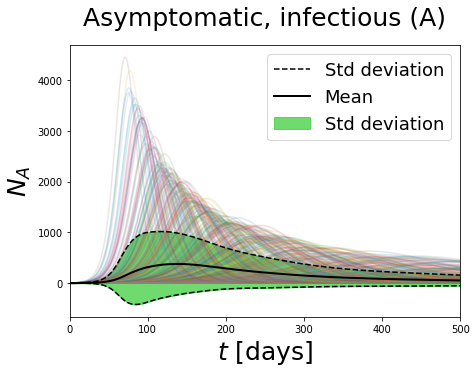

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


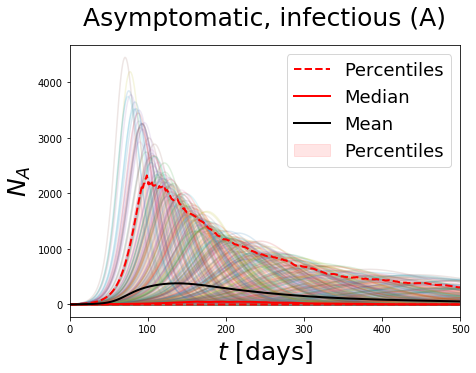

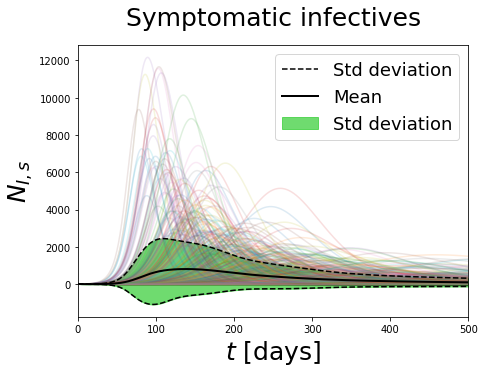

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


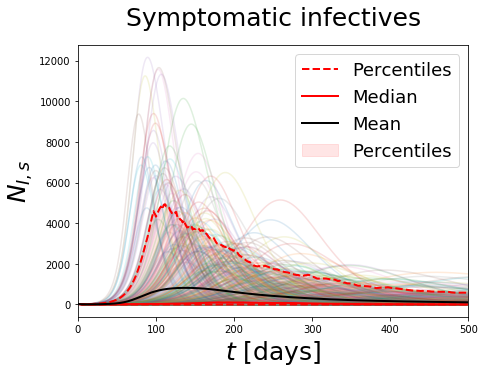

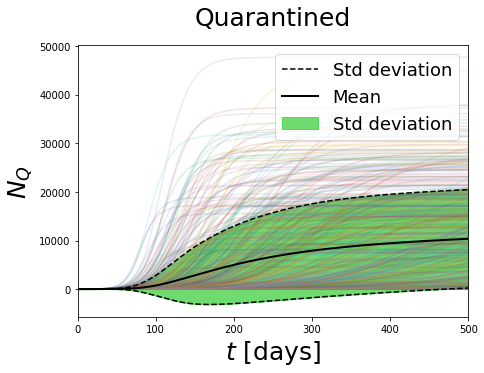

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


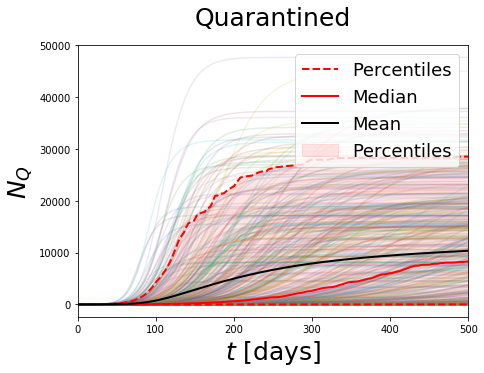

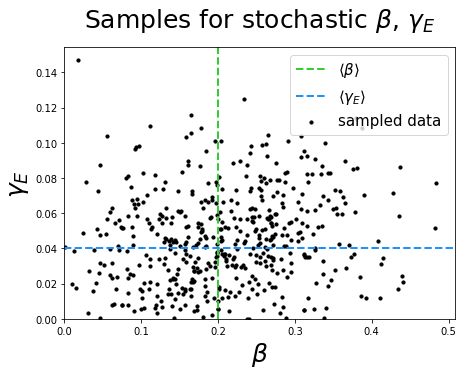

In [5]:
result = model_forecast.simulate(S0, E0, A0, Ia0, Is0, Q0,
                                 contactMatrix, Tf, Nt,
                                      verbose=True,
                                     Ns=Ns) 

plot_trajectories(result,
            plot_index = 2,
            percentile=5,
           )

plot_trajectories(result,
#            filename='forecast_deterministic',
            percentile=5,
           )

plot_trajectories(result,
            plot_index = 5,
            percentile=5,
           )

plot_sample_parameters(result)